In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 머신러닝 모델들
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

train = pd.read_excel('Train_dataset.xlsx')
answer = pd.read_excel('Answer_sheet.xlsx')
weather = pd.read_csv('weather.csv', encoding='CP949')

In [2]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   지점             8760 non-null   int64  
 1   일시             8760 non-null   object 
 2   기온(°C)         8756 non-null   float64
 3   강수량(mm)        849 non-null    float64
 4   풍속(m/s)        8760 non-null   float64
 5   풍향(16방위)       8760 non-null   int64  
 6   습도(%)          8746 non-null   float64
 7   증기압(hPa)       8756 non-null   float64
 8   이슬점온도(°C)      8756 non-null   float64
 9   현지기압(hPa)      8760 non-null   float64
 10  해면기압(hPa)      8760 non-null   float64
 11  일조(hr)         4796 non-null   float64
 12  일사(MJ/m2)      4794 non-null   float64
 13  적설(cm)         270 non-null    float64
 14  3시간신적설(cm)     44 non-null     float64
 15  전운량(10분위)      7657 non-null   float64
 16  중하층운량(10분위)    8719 non-null   float64
 17  운형(운형약어)       5005 non-null   object 
 18  최저운고(100

In [3]:
weather.rename(columns={"일시": "Time", "기온(°C)":"Temp", "풍속(m/s)": "WS", "습도(%)":"HMD", "일조(hr)": "Sun", "강수량(mm)": "prec"}, inplace=True)
weather['HMD'] = weather['HMD'].interpolate(method='linear')
weather['Temp'] = weather['Temp'].interpolate(method='linear')
weather = weather[['Time', "Temp", "HMD", "WS", "Sun", "prec"]]
weather = weather.fillna(0)

In [4]:
weather['Time'] = pd.to_datetime(weather['Time'], format='%Y-%m-%d %H:%M')
train['Time'] = pd.to_datetime(train['Time'], format='%Y%m%d_%H')
answer['Time'] = pd.to_datetime(answer['Time'], format='%Y%m%d_%H')
# train['Time'] = train['Time'].to_numpy(dtype='float64')
# train['Time'] = train['Time'].astype('int64')
display(weather)
display(train)

,Time,Temp,HMD,WS,Sun,prec
0,2018-01-01 00:00:00,-2.2,70.0,1.4,0.0,0.0
1,2018-01-01 01:00:00,-2.5,67.0,1.5,0.0,0.0
2,2018-01-01 02:00:00,-2.9,63.0,0.9,0.0,0.0
3,2018-01-01 03:00:00,-3.0,64.0,0.7,0.0,0.0
4,2018-01-01 04:00:00,-3.4,73.0,0.9,0.0,0.0
...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,-2.8,45.0,1.2,0.0,0.0
8756,2018-12-31 20:00:00,-3.5,47.0,1.2,0.0,0.0
8757,2018-12-31 21:00:00,-4.0,51.0,0.1,0.0,0.0
8758,2018-12-31 22:00:00,-4.6,58.0,1.1,0.0,0.0


,Time,Power
0,2018-01-01 00:00:00,105.760
1,2018-01-01 01:00:00,104.944
2,2018-01-01 02:00:00,105.552
3,2018-01-01 03:00:00,108.512
4,2018-01-01 04:00:00,102.896
...,...,...
7858,2018-12-31 18:00:00,141.440
7859,2018-12-31 19:00:00,149.632
7860,2018-12-31 20:00:00,154.624
7861,2018-12-31 21:00:00,162.688


In [5]:
train = pd.merge(train, weather, on='Time', how='inner')
answer = pd.merge(answer, weather, on='Time', how='inner')

In [6]:
display(train)

,Time,Power,Temp,HMD,WS,Sun,prec
0,2018-01-01 00:00:00,105.760,-2.2,70.0,1.4,0.0,0.0
1,2018-01-01 01:00:00,104.944,-2.5,67.0,1.5,0.0,0.0
2,2018-01-01 02:00:00,105.552,-2.9,63.0,0.9,0.0,0.0
3,2018-01-01 03:00:00,108.512,-3.0,64.0,0.7,0.0,0.0
4,2018-01-01 04:00:00,102.896,-3.4,73.0,0.9,0.0,0.0
...,...,...,...,...,...,...,...
7858,2018-12-31 18:00:00,141.440,-1.6,41.0,2.2,0.0,0.0
7859,2018-12-31 19:00:00,149.632,-2.8,45.0,1.2,0.0,0.0
7860,2018-12-31 20:00:00,154.624,-3.5,47.0,1.2,0.0,0.0
7861,2018-12-31 21:00:00,162.688,-4.0,51.0,0.1,0.0,0.0


In [7]:
train.columns.values

array(['Time', 'Power', 'Temp', 'HMD', 'WS', 'Sun', 'prec'], dtype=object)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7863 entries, 0 to 7862
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    7863 non-null   datetime64[ns]
 1   Power   7863 non-null   float64       
 2   Temp    7863 non-null   float64       
 3   HMD     7863 non-null   float64       
 4   WS      7863 non-null   float64       
 5   Sun     7863 non-null   float64       
 6   prec    7863 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 491.4 KB


In [9]:
#train['Month'] = train['Time'].dt.month
#train['Day'] = train['Time'].dt.day
#train['Hour'] = train['Time'].dt.hour
#answer['Month'] = answer['Time'].dt.month
#answer['Day'] = answer['Time'].dt.day
#answer['Hour'] = answer['Time'].dt.hour
# train['log_Power'] = np.log(train['Power'])

In [10]:
# display(train)
# display(answer)
# train['Time'] = train['Time'].to_numpy(dtype='float64')
# answer['Time'] = answer['Time'].to_numpy(dtype='float64')
# display(train)
# display(answer)

In [11]:
def make_time(data):
    cols = ['date_time', 'Power', 'temp', 'hum', 'wind','sun', 'prec']
    data.columns = cols
    # 시간 관련 변수들 생성
    date = pd.to_datetime(data.date_time)
    data['hour'] = date.dt.hour
    data['day'] = date.dt.weekday
    data['month'] = date.dt.month
    data['week'] = date.dt.weekofyear

In [12]:
## 변수들을 영문명으로 변경
cols = ['date_time', 'Power', 'temp', 'hum', 'wind','sun', 'prec']
train.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear

# #######################################
# ## 건물별, 요일별, 시간별 발전량 평균 넣어주기
# #######################################
# power_mean = pd.pivot_table(train, values = 'power', index = ['hour', 'day'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.hour == x['hour'])
#                                                                         & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 발전량 평균 넣어주기
# #######################################
# power_hour_mean = pd.pivot_table(train, values = 'power', index = ['hour'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[ (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 발전량 표준편차 넣어주기
# #######################################
# power_hour_std = pd.pivot_table(train, values = 'power', index = ['hour'], aggfunc = np.std).reset_index()
# tqdm.pandas()
# train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

### 공휴일 변수 추가
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

# cdhs = np.array([])
# for num in range(1,61,1):
#     temp = train[train['num'] == num]
#     cdh = CDH(temp['temp'].values)
#     cdhs = np.concatenate([cdhs, cdh])
# train['CDH'] = cdhs

#train.drop(['hour'], axis = 1, inplace = True)
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7863 entries, 0 to 7862
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  7863 non-null   datetime64[ns]
 1   Power      7863 non-null   float64       
 2   temp       7863 non-null   float64       
 3   hum        7863 non-null   float64       
 4   wind       7863 non-null   float64       
 5   sun        7863 non-null   float64       
 6   prec       7863 non-null   float64       
 7   hour       7863 non-null   int64         
 8   day        7863 non-null   int64         
 9   month      7863 non-null   int64         
 10  week       7863 non-null   int64         
 11  holiday    7863 non-null   int64         
 12  sin_time   7863 non-null   float64       
 13  cos_time   7863 non-null   float64       
 14  THI        7863 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(5)
memory usage: 982.9 KB


C:\Users\SungHyun\AppData\Local\Temp\ipykernel_7732\2699074623.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['week'] = date.dt.weekofyear


In [13]:
## 변수들을 영문명으로 변경
cols = ['date_time', 'temp', 'hum', 'wind', 'sun', 'prec']
answer.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(answer.date_time)
answer['hour'] = date.dt.hour
answer['day'] = date.dt.weekday
answer['month'] = date.dt.month
answer['week'] = date.dt.weekofyear

# #######################################
# ## 건물별, 요일별, 시간별 발전량 평균 넣어주기
# #######################################
# power_mean = pd.pivot_table(train, values = 'power', index = ['hour', 'day'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# answer['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.hour == x['hour'])
#                                                                         & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 발전량 평균 넣어주기
# #######################################
# power_hour_mean = pd.pivot_table(train, values = 'power', index = ['hour'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# answer['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[ (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 발전량 표준편차 넣어주기
# #######################################
# power_hour_std = pd.pivot_table(train, values = 'power', index = ['hour'], aggfunc = np.std).reset_index()
# tqdm.pandas()
# answer['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

### 공휴일 변수 추가
answer['holiday'] = answer.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
answer['sin_time'] = np.sin(2*np.pi*answer.hour/24)
answer['cos_time'] = np.cos(2*np.pi*answer.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
answer['THI'] = 9/5*answer['temp'] - 0.55*(1-answer['hum']/100)*(9/5*answer['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

# cdhs = np.array([])
# for num in range(1,61,1):
#     temp = train[train['num'] == num]
#     cdh = CDH(temp['temp'].values)
#     cdhs = np.concatenate([cdhs, cdh])
# train['CDH'] = cdhs

answer.drop(['hour', 'date_time'], axis = 1, inplace = True)
train.drop(['hour', 'date_time'], axis = 1, inplace = True)
answer.head()
answer.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      873 non-null    float64
 1   hum       873 non-null    float64
 2   wind      873 non-null    float64
 3   sun       873 non-null    float64
 4   prec      873 non-null    float64
 5   day       873 non-null    int64  
 6   month     873 non-null    int64  
 7   week      873 non-null    int64  
 8   holiday   873 non-null    int64  
 9   sin_time  873 non-null    float64
 10  cos_time  873 non-null    float64
 11  THI       873 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 88.7 KB


C:\Users\SungHyun\AppData\Local\Temp\ipykernel_7732\4064333188.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  answer['week'] = date.dt.weekofyear


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7863 entries, 0 to 7862
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Power     7863 non-null   float64
 1   temp      7863 non-null   float64
 2   hum       7863 non-null   float64
 3   wind      7863 non-null   float64
 4   sun       7863 non-null   float64
 5   prec      7863 non-null   float64
 6   day       7863 non-null   int64  
 7   month     7863 non-null   int64  
 8   week      7863 non-null   int64  
 9   holiday   7863 non-null   int64  
 10  sin_time  7863 non-null   float64
 11  cos_time  7863 non-null   float64
 12  THI       7863 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 860.0 KB


In [15]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7863 entries, 0 to 7862
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Power     7863 non-null   float64
 1   temp      7863 non-null   float64
 2   hum       7863 non-null   float64
 3   wind      7863 non-null   float64
 4   sun       7863 non-null   float64
 5   prec      7863 non-null   float64
 6   day       7863 non-null   int64  
 7   month     7863 non-null   int64  
 8   week      7863 non-null   int64  
 9   holiday   7863 non-null   int64  
 10  sin_time  7863 non-null   float64
 11  cos_time  7863 non-null   float64
 12  THI       7863 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 860.0 KB


In [16]:
# Q1 = np.percentile(train['Power'], 25)
# Q3 = np.percentile(train['Power'], 75)

# # Calculate the interquartile range
# IQR = Q3 - Q1

# # Define the outlier bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# print(lower_bound,upper_bound)
# # Identify the outliers
# outliers = [x for x in train['Power'] if x < lower_bound or x > upper_bound]

# # Print the results
# # print("Outliers:", outliers)
# # print(len(outliers))
def remove_outlier(d_cp, column):
    fraud_column_data = d_cp[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)

    iqr = quan_75 - quan_25
    iqr_weight = iqr * 1.5
    lowest = quan_25 - iqr_weight
    highest = quan_75 + iqr_weight

    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    d_cp.drop(outlier_index, axis=0, inplace=True)
    return d_cp

In [17]:
def remove_zscore(d_cp, column):
    mean = d_cp[column].mean()
    std = d_cp[column].std()

    # 열 'A'의 Z-score 계산
    d_cp['Z'] = (d_cp[column] - mean) / std

    # Z-score의 절대값이 3보다 큰 행 제거
    d_cp = d_cp[np.abs(d_cp['Z']) <= 3]
    
    return d_cp

In [18]:
# train = remove_outlier(train, 'Power')
# df = train.sort_values(by='Power')

# print(df)

In [19]:
# #데이터 스케일링
# # scaler = StandardScaler()
# # train = scaler.fit_transform(train)

# exclude_columns = ['Time']

# # Select the columns to scale
# columns_to_scale = [col for col in train.columns if col not in exclude_columns]
# df_to_scale = train[columns_to_scale]
# # df_to_scale = train

# # Fit the scaler on the selected columns
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df_to_scale)

# # Create a new DataFrame with the scaled data
# scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
# # scaled_df = pd.DataFrame(scaled_data)

# # Add the excluded columns back to the scaled DataFrame
# scaled_df[exclude_columns] = train[exclude_columns]

# display(scaled_df)
# train = scaled_df
# train.info()

In [20]:
# # Select the columns that were scaled
# columns_to_inverse_scale = [col for col in scaled_df.columns if col not in exclude_columns]
# df_to_inverse_scale = scaled_df[columns_to_inverse_scale]
# print(df_to_inverse_scale)
# # Inverse transform the scaled data
# inverse_scaled_data = scaler.inverse_transform(df_to_inverse_scale)

# # Create a new DataFrame with the inverse scaled data
# inverse_scaled_df = pd.DataFrame(inverse_scaled_data, columns=columns_to_inverse_scale)

# # Add the excluded columns back to the inverse scaled DataFrame
# inverse_scaled_df[exclude_columns] = scaled_df[exclude_columns]

# display(inverse_scaled_df)

        Power  temp   hum  wind  sun  prec  day  month  week  holiday  \
6619    1.536   7.4  83.0   0.0  1.0   0.0    0     11    45        0   
7122    9.088   4.9  46.0   0.4  0.0   0.0    2     11    48        0   
6353   30.208  17.0  52.0   1.2  1.0   0.0    2     10    43        0   
6627   37.376  16.2  41.0   1.1  0.8   0.0    0     11    45        0   
6628   37.888  14.3  55.0   1.2  0.0   0.0    0     11    45        0   
...       ...   ...   ...   ...  ...   ...  ...    ...   ...      ...   
101   246.256  -1.2  66.0   1.1  0.0   0.0    4      1     1        0   
3268  246.272  29.8  25.0   2.6  1.0   0.0    5      6    22        1   
93    246.304   1.4  44.0   1.2  1.0   0.0    4      1     1        0   
184   246.384  -0.8  74.0   1.3  0.0   0.0    1      1     2        0   
356   246.400   5.6  91.0   1.3  0.0   0.0    2      1     3        0   

          sin_time      cos_time      THI  
6619  7.071068e-01 -7.071068e-01  33.7821  
7122  5.000000e-01 -8.660254e-01  2

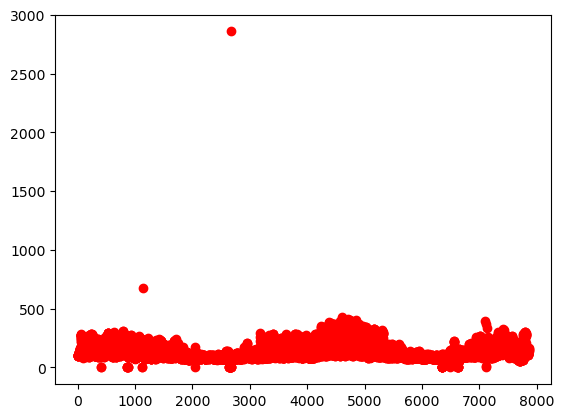

In [21]:
plt.plot(train['Power'], 'ro')
train = remove_outlier(train,'Power')
# train = remove_zscore(train,'Power')
# 열 'A'에서 값이 0인 행 제거
train = train[train['Power'] != 0]
df = train.sort_values(by='Power')

print(df)

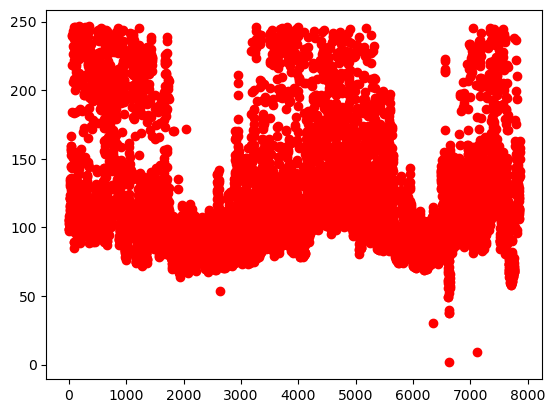

In [22]:
plt.plot(train['Power'], 'ro')

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7223 entries, 0 to 7862
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Power     7223 non-null   float64
 1   temp      7223 non-null   float64
 2   hum       7223 non-null   float64
 3   wind      7223 non-null   float64
 4   sun       7223 non-null   float64
 5   prec      7223 non-null   float64
 6   day       7223 non-null   int64  
 7   month     7223 non-null   int64  
 8   week      7223 non-null   int64  
 9   holiday   7223 non-null   int64  
 10  sin_time  7223 non-null   float64
 11  cos_time  7223 non-null   float64
 12  THI       7223 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 790.0 KB


In [24]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
features = ['temp', 'hum', 'wind','sun', 'prec', 'day', 'month', 'week', 'holiday', 'sin_time', 'cos_time', 'THI']

df = train

X2 = train[features]
Y2 = train['Power']

train, test = train_test_split(df, test_size=0.2)
# test = train[-279:]


X_train = train[features]
Y_train = train['Power']

X_test = test[features]
y_test = test['Power']

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(y_test.shape)

# hyperparameter
# n_estimators : 트리 개수
# n_jobs : 사용할 cpu 개수 (-1로 설정하면 가장 많은 cpu 사용 가능)
# max_depth: 모델의 과대 적합 방지를 위한 깊이 설정 변수
# random_state : random 성질을 고정시킴

# 해당 데이터에 가장 적합한 hyparameter 옵션을 찾는 과정 => tuning
model1 = RandomForestRegressor(n_estimators=100, criterion = 'squared_error', n_jobs = -1)   # Decision Tree 모델을 여러 개 모아서 만든 것 = Random Forest
model2 = RandomForestRegressor(criterion = 'squared_error', n_jobs = -1)
model3 = RandomForestRegressor(n_estimators=200, criterion = 'squared_error') 
model4= RandomForestRegressor(n_estimators= 400, criterion = 'squared_error')

(5778, 12)
(5778,)
(1445, 12)
(1445,)


In [25]:
# from sklearn.model_selection import GridSearchCV

# # rf = RandomForestRegressor()

# # # 탐색할 파라미터
# # params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}

# # # GridSearchCV 클래스의 인스턴스 생성
# # gscv = GridSearchCV(rf, params, cv=5)

# # # GridSearchCV 클래스의 fit() 메서드 호출
# # gscv.fit(X_train, Y_train)

# # # 최적 파라미터 출력
# # print(gscv.best_params_)

# rf_reg = RandomForestRegressor(random_state=0)
# params = {
#     'n_estimators': [10, 30, 50, 20, 40, 200],
# #     'max_depth': [2, 5, 8]
# }
# # 그리드 검색 객체 생성
# grid_cv = GridSearchCV(rf_reg, param_grid=params, cv=5)

# # 그리드 검색 수행
# grid_cv.fit(X_train, Y_train)

# # 최적의 하이퍼 파라미터 출력
# print('최적의 하이퍼 파라미터:', grid_cv.best_params_)

최적의 하이퍼 파라미터: {'n_estimators': 200}


In [26]:
# X_train = X_train.astype('float64')


model1.fit(X_train, Y_train)
model2.fit(X_train, Y_train)
model3.fit(X_train, Y_train)
model4.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=400)

In [27]:
start = '2018-01-01-01'
end = '2018-12-31-23'

ypred1 = model1.predict(X_test)
ypred2 = model2.predict(X_test)
ypred3 = model3.predict(X_test)
ypred4 = model4.predict(X_test)

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def calRmse(p, a):
    rmse = sqrt(mean_squared_error(p, a))
    return rmse

In [29]:
print(calRmse(ypred1, y_test))
print(calRmse(ypred2, y_test))
print(calRmse(ypred3, y_test))
print(calRmse(ypred4, y_test))

16.078906006594885
15.782256837753113
15.875520780680827
16.012258868015234


In [30]:
from sklearn import metrics

print("accuracy: {}".format(model1.score(X_test, y_test)))
print("accuracy: {}".format(model2.score(X_test, y_test)))
print("accuracy: {}".format(model3.score(X_test, y_test)))
print("accuracy: {}".format(model4.score(X_test, y_test)))

accuracy: 0.8672944181745745
accuracy: 0.8721459731361151
accuracy: 0.8706304227001831
accuracy: 0.8683922686329864


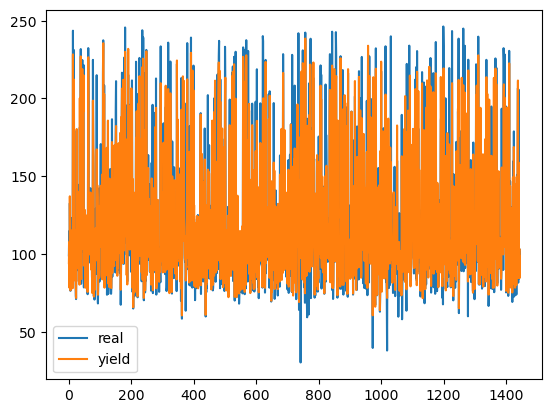

In [31]:
x1 = range(len(ypred1))

plt.plot(x1, y_test)
plt.plot(x1, ypred1)
plt.legend(['real', 'yield'])
plt.show()

In [32]:
X_test.head()

,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI
2989,17.4,51.0,5.8,0.3,0.0,6,5,20,1,-0.866025,0.500000,45.5869
1967,24.4,49.0,2.2,0.7,0.0,1,4,14,0,-0.500000,-0.866025,58.4729
6462,8.6,97.0,0.5,0.7,0.0,0,10,44,0,0.707107,-0.707107,45.0281
5254,27.3,91.0,0.7,0.2,0.1,0,9,36,0,-0.866025,-0.500000,74.3189
438,-3.7,95.0,0.1,0.0,0.0,6,1,3,1,0.707107,-0.707107,21.3525


In [33]:
display(y_test)

2989     99.136
1967    114.624
6462     86.272
5254    132.608
438     103.360
         ...   
846     205.696
1191     84.128
6116    101.504
6372     87.680
4314    102.656
Name: Power, Length: 1445, dtype: float64

In [34]:
answer.head()
answer.info()
answer[answer.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      873 non-null    float64
 1   hum       873 non-null    float64
 2   wind      873 non-null    float64
 3   sun       873 non-null    float64
 4   prec      873 non-null    float64
 5   day       873 non-null    int64  
 6   month     873 non-null    int64  
 7   week      873 non-null    int64  
 8   holiday   873 non-null    int64  
 9   sin_time  873 non-null    float64
 10  cos_time  873 non-null    float64
 11  THI       873 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 88.7 KB


,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI


In [35]:
# create final model

y_pred = model3.predict(answer)

In [36]:
model3.feature_importances_

array([0.21045881, 0.041262  , 0.02529942, 0.01415466, 0.00160588,
       0.1776705 , 0.08058103, 0.17908519, 0.00479626, 0.10690626,
       0.09611007, 0.06206992])

In [37]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["Power"]
display(y_pred)

,Power
0,115.66936
1,129.92024
2,136.89400
3,137.11296
4,101.25440
...,...
868,130.20672
869,128.84184
870,122.44448
871,147.77688


In [38]:
# # Let's assume that the original DataFrame has 4 columns: A, B, C, and D
# # And that ypred contains the scaled data for column C

# # Create a new DataFrame with the same number of rows as ypred and 4 columns filled with zeros
# df = pd.DataFrame(np.zeros((y_pred.shape[0], 3)), columns=['Power', 'Temp', 'HMD'])

# # Set the values in column C to the values in ypred
# df['Power'] = y_pred

# # Use the inverse_transform method on the new DataFrame
# original_data = scaler.inverse_transform(df)

# # Extract the values in column C from the inverse transformed data
# original_C = original_data[:, 0]

# original_df = pd.DataFrame(original_data, columns=['Power', 'Temp', 'HMD'])

# original_df.info()
# display(original_df)
# y_pred = original_df['Power']

In [39]:
display(y_pred)
display(answer)
result = pd.concat([answer, y_pred], axis=1)
# result['Time'] = result['Time'].apply(lambda x: pd.to_datetime(str(float(x)), format='%Y%m%d_%H'))
# result['Time'] = pd.to_datetime(str(float(result['Time'])), format='%Y%m%d_%H')

# result['Time'] = result['Time'].dt.strftime('%Y%m%d_%H')
result = result.reindex(['Time', 'Power', 'Temp', 'HMD'], axis=1)
display(result)

,Power
0,112.87272
1,133.69840
2,137.25968
3,131.26624
4,101.69432
...,...
868,142.27088
869,127.86104
870,127.60136
871,153.62056


,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI
0,4.5,34.0,2.2,1.0,0.0,0,1,1,0,-0.500000,-0.866025,27.3224
1,3.2,47.0,1.1,0.6,0.0,0,1,1,0,-0.965926,-0.258819,20.6781
2,1.0,56.0,0.7,0.0,0.0,0,1,1,0,-0.965926,0.258819,15.6984
3,-2.2,72.0,0.3,0.0,0.0,0,1,1,0,-0.258819,0.965926,12.0856
4,-5.2,82.0,1.1,0.0,0.0,0,1,1,0,0.866025,-0.500000,10.6016
...,...,...,...,...,...,...,...,...,...,...,...,...
868,-0.6,30.0,1.5,1.0,0.0,6,12,52,1,-0.707107,-0.707107,20.1400
869,-5.9,53.0,1.2,0.0,0.0,0,12,1,0,0.000000,1.000000,3.4401
870,0.2,36.0,0.7,1.0,0.0,0,12,1,0,-0.258819,-0.965926,18.7024
871,0.1,33.0,2.9,0.7,0.0,0,12,1,0,-0.965926,-0.258819,19.8721


,Time,Power,Temp,HMD
0,NaN,112.87272,NaN,NaN
1,NaN,133.69840,NaN,NaN
2,NaN,137.25968,NaN,NaN
3,NaN,131.26624,NaN,NaN
4,NaN,101.69432,NaN,NaN
...,...,...,...,...
868,NaN,142.27088,NaN,NaN
869,NaN,127.86104,NaN,NaN
870,NaN,127.60136,NaN,NaN
871,NaN,153.62056,NaN,NaN


In [40]:
# Select the columns that were scaled
# columns_to_inverse_scale = [col for col in result.columns if col not in exclude_columns]
# df_to_inverse_scale = result[columns_to_inverse_scale]

# print(df_to_inverse_scale)

# # Inverse transform the scaled data
# inverse_scaled_data = scaler.inverse_transform(df_to_inverse_scale)

# # Create a new DataFrame with the inverse scaled data
# inverse_scaled_df = pd.DataFrame(result, columns=columns_to_inverse_scale)

# # Add the excluded columns back to the inverse scaled DataFrame
# inverse_scaled_df[exclude_columns] = result[exclude_columns]

# display(inverse_scaled_df)

In [41]:
real_answer = pd.read_excel('Answer_sheet.xlsx')
real_answer = pd.concat([real_answer, result['Power']], axis=1)
display(real_answer)

,Time,Power
0,20180101_14,112.87272
1,20180101_17,133.69840
2,20180101_19,137.25968
3,20180101_23,131.26624
4,20180101_08,101.69432
...,...,...
868,20181230_15,142.27088
869,20181231_00,127.86104
870,20181231_13,127.60136
871,20181231_17,153.62056


In [42]:
real_answer.to_excel('predict_RF.xlsx', index=False)

In [43]:
# train = pd.read_excel('Train_dataset.xlsx')
# real_answer['Time'] = pd.to_datetime(real_answer['Time'], format='%Y%m%d_%H')
# train['Time'] = pd.to_datetime(train['Time'], format='%Y%m%d_%H')
# df_total = pd.concat([real_answer, train], ignore_index=True)
# df_total = df_total.sort_values(by='Time')
# display(df_total)

In [44]:
# df_total.plot(x='Time', y='Power')
# plt.show()

In [45]:
# import pandas as pd

# # Load the data
# df = pd.read_excel("Train_dataset.xlsx")

# # Identify the missing data
# missing_data = df[df.isna().any(axis=1)]

# # Use a linear interpolation method to estimate the missing data
# df.loc[missing_data.index, missing_data.columns] = df.loc[missing_data.index, missing_data.columns].interpolate()

# # Save the data
# # df.to_csv("power_consumption_data_interpolated.csv",index=False)
# display(df)

In [46]:
# plt.plot(df['Power'], label="Original data")
# plt.plot(train['Power'], label="Interpolated data")
# plt.legend()
# plt.show()

In [47]:
# features = ['Time']
# test = df[-279:]

# X_train = df[features]
# Y_train = df['Power']

# X_test = df[features]
# y_test = df['Power']

# model = RandomForestRegressor(criterion = 'squared_error')
# model.fit(X_train, Y_train)
# ypred = model.predict(X_test)


# print(calRmse(ypred, y_test))
# print("accuracy: {}".format(model.score(X_test, y_test)))

In [48]:
# from sklearn.tree import DecisionTreeRegressor

# # Create the decision tree regressor
# regressor = DecisionTreeRegressor()

# features = ['Time']
# test = train[-279:]

# X_train = train[features]
# Y_train = train['Power']

# X_test = test[features]
# y_test = test['Power']

# # Fit the model to the training data
# regressor.fit(X_train, Y_train)

# # Predict the target variable for new data
# y_pred = regressor.predict(X_test)
# print(calRmse(y_pred, y_test))
# y_pred = regressor.predict(answer)

In [49]:
# y_pred = pd.DataFrame(y_pred)
# y_pred.columns = ["Power"]
# display(y_pred)
# display(answer)
# result = pd.concat([answer, y_pred], axis=1)
# result['Time'] = result['Time'].dt.strftime('%Y%m%d_%H')

# display(result)
# print(calRmse(y_pred, y_pred4))

In [50]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb.fit(X_train, Y_train)

ypred1 = xgb.predict(X_test)

print(calRmse(ypred1, y_test))

16.929073597188225


In [51]:
X_test.head()

,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI
5887,16.9,72.0,1.1,0.0,0.0,1,10,40,0,-0.965926,0.258819,46.4656
3584,18.6,86.0,0.3,0.3,0.0,6,6,24,1,0.965926,-0.258819,55.5624
1453,3.8,70.0,2.4,0.0,0.0,5,3,10,1,-0.500000,0.866025,22.3400
7281,4.6,45.0,1.2,0.9,0.0,2,12,49,0,-0.258819,-0.965926,23.6425
2714,17.0,92.0,0.5,0.0,0.0,0,5,19,0,-0.707107,0.707107,56.4576


In [52]:
xgb_grid_best_params_ = {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'gamma': 20, 
                         'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 
                         'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}
best_params = xgb_grid_best_params_

xgb = XGBRegressor(**best_params, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb.fit(X_train, Y_train)

ypred1 = xgb.predict(X_test)

print(calRmse(ypred1, y_test))

21.415455519254447


In [62]:
# # Various hyper-parameters to tune
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()
xgb1 = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'eval_metric':['rmse'],
              'gamma':[10, 20, 50, 100],
              'learning_rate': [0.05, .1, .15], #so called `eta` value
              'max_depth': [4, 5, 6],
              'min_child_weight': [4, 5, 6],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [10, 50, 100, 200]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        verbose=3)

xgb_grid.fit(X2, Y2)

end_time = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print(f'소요시간: {(end_time - start_time)} 초')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-2.844 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-3.855 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-3.385 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.123 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gam

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.122 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.411 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.257 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.117 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=5, min_child_weight=4, n_est

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.237 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.089 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.048 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.194 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.05, max_depth=6, min_child_weight=4, n_es

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.165 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.081 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.221 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.168 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estim

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.164 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.092 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.259 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.349 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estim

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.287 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.277 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-2.017 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.853 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estima

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.108 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.200 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.038 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.165 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=4, min_child_weight=5, n_esti

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.023 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.137 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.225 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.169 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=5, min_child_weight=5, n_

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.134 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.106 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.076 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.163 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=10, learning_rate=0.15, max_depth=6, min_child_weight=5, n

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.201 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.054 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.077 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-2.844 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=4, min_child_weight=6, n_e

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.071 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-2.855 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-3.839 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-3.307 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=5, min_child_weight=6, n_es

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.145 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.355 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.248 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.092 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.05, max_depth=6, min_child_weight=6, n_est

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.179 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.182 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.167 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.098 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimat

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=5, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.083 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=5, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.001 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=5, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.205 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=5, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.097 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=5, min_child_weight=6, n_estim

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.105 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.188 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.153 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=4, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.652 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=4, min_child_weight=4, n_est

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=4, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.192 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.606 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.127 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.045 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=5, min_child_weight=4, n_e

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.084 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.118 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.020 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.090 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=20, learning_rate=0.15, max_depth=6, min_child_weight=4, n_est

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.258 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.125 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.167 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=4, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.225 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=4, min_child_weight=4, n_es

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.100 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.205 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.156 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.072 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=5, min_child_weight=4, n_

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.147 total time=   0.5s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.050 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=6, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.012 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-2.767 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.05, max_depth=6, min_child_weight=5, n_e

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.110 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.323 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.784 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.911 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estima

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.126 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.145 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.159 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.190 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimator

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.133 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.121 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.195 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.006 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimat

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.191 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.088 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.179 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.219 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=4, min_child_weight=5, n

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.113 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.165 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.426 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=5, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.566 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=5, min_child_weight=6, n_

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.434 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=6, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.603 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=6, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.041 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=6, min_child_weight=6, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.008 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=50, learning_rate=0.15, max_depth=6, min_child_weight=6, n_es

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.119 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.433 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.268 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.120 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=4, min_child_weight=6, 

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.271 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.091 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.121 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=5, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.201 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=5, min_child_weight=6,

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.066 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.191 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.133 total time=   0.5s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.043 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.05, max_depth=6, min_child_weight=

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.173 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.234 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.101 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.354 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=5, min_child_weight=4, n_

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=5, min_child_weight=6, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.121 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-1.282 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-2.019 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=10, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.827 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.1, max_depth=6, min_child_weight=4, n_e

[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=4, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.129 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=4, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.131 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=4, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.029 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=4, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.201 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=4, min_child_weight=4, n

[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=50, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.046 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.145 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.167 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=5, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.186 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=5, min_child_weight=

[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.131 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=100, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.177 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=0.128 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=6, min_child_weight=4, n_estimators=200, nthread=4, objective=reg:squarederror, subsample=0.7;, score=-0.199 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, eval_metric=rmse, gamma=100, learning_rate=0.15, max_depth=6, min_child_weight

In [63]:
xgb_grid_best_params_ = {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'gamma': 10, 'learning_rate': 0.15, 'max_depth': 6, 
 'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}

# best_params = xgb_grid_best_params_

xgb = XGBRegressor(**best_params, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb.fit(X_train, Y_train)

ypred1 = xgb.predict(X_test)

print(calRmse(ypred1, y_test))

16.834227587768535


In [64]:
display(X2)

,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI
0,-2.2,70.0,1.4,0.0,0.0,0,1,1,0,0.000000,1.000000e+00,11.5400
1,-2.5,67.0,1.5,0.0,0.0,0,1,1,0,0.258819,9.659258e-01,10.3301
2,-2.9,63.0,0.9,0.0,0.0,0,1,1,0,0.500000,8.660254e-01,8.9941
3,-3.0,64.0,0.7,0.0,0.0,0,1,1,0,0.707107,7.071068e-01,8.9384
4,-3.4,73.0,0.9,0.0,0.0,0,1,1,0,0.866025,5.000000e-01,10.2281
...,...,...,...,...,...,...,...,...,...,...,...,...
7858,-1.6,41.0,2.2,0.0,0.0,0,12,1,0,-1.000000,-1.836970e-16,13.6089
7859,-2.8,45.0,1.2,0.0,0.0,0,12,1,0,-0.965926,2.588190e-01,10.3225
7860,-3.5,47.0,1.2,0.0,0.0,0,12,1,0,-0.866025,5.000000e-01,8.6181
7861,-4.0,51.0,0.1,0.0,0.0,0,12,1,0,-0.707107,7.071068e-01,7.0669


In [65]:
answer = pd.read_excel('Answer_sheet.xlsx')

answer['Time'] = pd.to_datetime(answer['Time'], format='%Y%m%d_%H')

answer = pd.merge(answer, weather, on='Time', how='inner')

## 변수들을 영문명으로 변경
cols = ['date_time', 'temp', 'hum', 'wind', 'sun', 'prec']
answer.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(answer.date_time)
answer['hour'] = date.dt.hour
answer['day'] = date.dt.weekday
answer['month'] = date.dt.month
answer['week'] = date.dt.weekofyear

# #######################################
# ## 건물별, 요일별, 시간별 발전량 평균 넣어주기
# #######################################
# power_mean = pd.pivot_table(train, values = 'power', index = ['hour', 'day'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# answer['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.hour == x['hour'])
#                                                                         & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 발전량 평균 넣어주기
# #######################################
# power_hour_mean = pd.pivot_table(train, values = 'power', index = ['hour'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# answer['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[ (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 발전량 표준편차 넣어주기
# #######################################
# power_hour_std = pd.pivot_table(train, values = 'power', index = ['hour'], aggfunc = np.std).reset_index()
# tqdm.pandas()
# answer['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

### 공휴일 변수 추가
answer['holiday'] = answer.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
answer['sin_time'] = np.sin(2*np.pi*answer.hour/24)
answer['cos_time'] = np.cos(2*np.pi*answer.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
answer['THI'] = 9/5*answer['temp'] - 0.55*(1-answer['hum']/100)*(9/5*answer['hum']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

# cdhs = np.array([])
# for num in range(1,61,1):
#     temp = train[train['num'] == num]
#     cdh = CDH(temp['temp'].values)
#     cdhs = np.concatenate([cdhs, cdh])
# train['CDH'] = cdhs

answer.drop(['hour', 'date_time'], axis = 1, inplace = True)
answer.head()
answer.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      873 non-null    float64
 1   hum       873 non-null    float64
 2   wind      873 non-null    float64
 3   sun       873 non-null    float64
 4   prec      873 non-null    float64
 5   day       873 non-null    int64  
 6   month     873 non-null    int64  
 7   week      873 non-null    int64  
 8   holiday   873 non-null    int64  
 9   sin_time  873 non-null    float64
 10  cos_time  873 non-null    float64
 11  THI       873 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 88.7 KB


C:\Users\sunghyun\AppData\Local\Temp\ipykernel_28972\1078993027.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  answer['week'] = date.dt.weekofyear


In [66]:
xgb = XGBRegressor(**best_params, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xgb.fit(X2, Y2)

ypred = xgb.predict(answer)

y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["Power"]
display(y_pred)

,Power
0,112.87272
1,133.69840
2,137.25968
3,131.26624
4,101.69432
...,...
868,142.27088
869,127.86104
870,127.60136
871,153.62056


In [67]:
display(answer)
result = pd.concat([answer, y_pred], axis=1)
# result['Time'] = result['Time'].apply(lambda x: pd.to_datetime(str(float(x)), format='%Y%m%d_%H'))
# result['Time'] = pd.to_datetime(str(float(result['Time'])), format='%Y%m%d_%H')

# result['Time'] = result['Time'].dt.strftime('%Y%m%d_%H')
result = result.reindex(['Time', 'Power', 'temp', 'hum'], axis=1)
display(result)

,temp,hum,wind,sun,prec,day,month,week,holiday,sin_time,cos_time,THI
0,4.5,34.0,2.2,1.0,0.0,0,1,1,0,-0.500000,-0.866025,27.3224
1,3.2,47.0,1.1,0.6,0.0,0,1,1,0,-0.965926,-0.258819,20.6781
2,1.0,56.0,0.7,0.0,0.0,0,1,1,0,-0.965926,0.258819,15.6984
3,-2.2,72.0,0.3,0.0,0.0,0,1,1,0,-0.258819,0.965926,12.0856
4,-5.2,82.0,1.1,0.0,0.0,0,1,1,0,0.866025,-0.500000,10.6016
...,...,...,...,...,...,...,...,...,...,...,...,...
868,-0.6,30.0,1.5,1.0,0.0,6,12,52,1,-0.707107,-0.707107,20.1400
869,-5.9,53.0,1.2,0.0,0.0,0,12,1,0,0.000000,1.000000,3.4401
870,0.2,36.0,0.7,1.0,0.0,0,12,1,0,-0.258819,-0.965926,18.7024
871,0.1,33.0,2.9,0.7,0.0,0,12,1,0,-0.965926,-0.258819,19.8721


,Time,Power,temp,hum
0,NaN,112.87272,4.5,34.0
1,NaN,133.69840,3.2,47.0
2,NaN,137.25968,1.0,56.0
3,NaN,131.26624,-2.2,72.0
4,NaN,101.69432,-5.2,82.0
...,...,...,...,...
868,NaN,142.27088,-0.6,30.0
869,NaN,127.86104,-5.9,53.0
870,NaN,127.60136,0.2,36.0
871,NaN,153.62056,0.1,33.0


In [68]:
real_answer = pd.read_excel('Answer_sheet.xlsx')
real_answer = pd.concat([real_answer, result['Power']], axis=1)
display(real_answer)

,Time,Power
0,20180101_14,112.87272
1,20180101_17,133.69840
2,20180101_19,137.25968
3,20180101_23,131.26624
4,20180101_08,101.69432
...,...,...
868,20181230_15,142.27088
869,20181231_00,127.86104
870,20181231_13,127.60136
871,20181231_17,153.62056


In [69]:
real_answer.to_excel('predict_XG.xlsx', index=False)

In [ ]:
{'eval_metric': 'rmse', 'gamma': 5, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 50, 'objective': 'reg:squarederror'}